In [1]:
#importing all relavent libraries, not some are not used 
import os
import h5py
import numpy as np
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import h5py
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import scipy.signal as sig
import matplotlib.pyplot as plt
import time

In [24]:
#location of training files, toy files are provided on the repo.
data_directory = "" #use if training files are in the same folder as this code 
data = np.load(data_directory + "./psd_data.npy") #includes PSD graphs
params = np.load(data_directory + "./psd_params.npy") #includes corresponding parameters

In [25]:
#important normalization condition
#the average value must be copied over to pipeline code

print("avg val,", np.average(data))
data -= np.average(data)

avg val, -45.40562017962998


In [26]:
#shuffle the data in unison
p = np.random.permutation(len(data))
data = data[p]
params = params[p]

In [27]:
#neural network hyperparameters
batch_size = 50
input_shape = (20,)
epochs = 5

In [28]:
#split data beteween training and testing

split = 47500
test_split = split
x_train = data[:split, :]
x_test = data[test_split:, :]

y_train = params[:split, :]
y_test = params[test_split:, :]

print("{}:xtrain, {}:xtest, {}:ytrain, {}:ytest".
      format(x_train.shape, x_test.shape, y_train.shape,y_test.shape))

(47500, 20):xtrain, (2500, 20):xtest, (47500, 2):ytrain, (2500, 2):ytest


In [29]:
# define neural network model
model = Sequential()
model.add(Dense(1024, activation = 'relu', 
                input_shape = input_shape))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              21504     
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 2,122,242
Trainable params: 2,122,242
No

In [30]:
#compile model with relevant loss, optimizer, and metric
model.compile(loss='mean_absolute_error',
              optimizer="adam",
              metrics=tf.keras.metrics.MeanAbsoluteError())

#fit to the training data
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

#evaluate the preformance on the testing set
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
950/950 [==============================] - 30s 30ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0266 - val_mean_absolute_error: 0.0266
Epoch 2/5
950/950 [==============================] - 29s 30ms/step - loss: 0.0253 - mean_absolute_error: 0.0253 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233
Epoch 3/5
950/950 [==============================] - 28s 30ms/step - loss: 0.0232 - mean_absolute_error: 0.0232 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192
Epoch 4/5
950/950 [==============================] - 28s 30ms/step - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230
Epoch 5/5
950/950 [==============================] - 29s 31ms/step - loss: 0.0213 - mean_absolute_error: 0.0213 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Test loss: 0.020980827510356903
Test accuracy: 0.020980827510356903


In [14]:
#save the model to relevant location, will need this for the pipeline simulation
model_save_directory = "" #save model to same the same folder as this program
model.save(model_save_directory + "./parameter_estimation_network.h5", include_optimizer = False)


In [28]:
def mae(x, y):
    N = len(x)
    assert(N == len(y))
    return np.sum(abs(x-y), axis=0)/N

In [33]:
test_predictions = model.predict(x_test)

mass_error = mae(test_predictions[:, 0], y_test[:, 0])
e_error = mae(test_predictions[:, 1], y_test[:, 1])
print(f"Average error in chirp mass prediction: {mass_error:.4f}")
print(f"Average error in eccentricity prediction: {e_error:.4f}")

Average error in chirp mass prediction: 0.0081
Average error in eccentricity prediction: 0.0310


In [34]:
#plotting parameters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams as rc
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
lw1 = 3.6
lw2 = 2.4
lw3 = 2.4
ft1 = 30
ft2 = 30
lg = 26
tl1 = 12
tl2 = 8
rc.update({'figure.figsize': (12,9)})
rc.update({'axes.labelsize': ft1})
rc.update({'axes.titlesize': ft1})
rc.update({'axes.linewidth': lw2})
rc.update({'lines.linewidth': lw1})
rc.update({'axes.formatter.limits': (-4,4)})
rc.update({'lines.markersize': 20.})
rc.update({'lines.markeredgewidth': lw1})
rc.update({'markers.fillstyle': 'none'})
rc.update({'xtick.labelsize': ft2})
rc.update({'ytick.labelsize': ft2})
rc.update({'xtick.direction': 'out'})
rc.update({'ytick.direction': 'out'})
rc.update({'xtick.major.size': tl1})
rc.update({'ytick.major.size': tl1})
rc.update({'xtick.minor.size': tl2})
rc.update({'ytick.minor.size': tl2})
rc.update({'xtick.minor.width': lw3})
rc.update({'xtick.major.width': lw3})
rc.update({'xtick.minor.width': lw3})
rc.update({'ytick.major.width': lw3})
rc.update({'ytick.minor.width': lw3})
rc.update({'xtick.major.pad': '8'})
rc.update({'ytick.major.pad': '10'})
rc.update({'xtick.top': False})
rc.update({'ytick.right': False})
rc.update({'legend.fontsize': lg})
rc.update({'legend.numpoints': 1})
rc.update({'legend.frameon': False})
rc.update({'font.family':'STIXGeneral','mathtext.fontset':'stix'})

cols = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd',
        u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

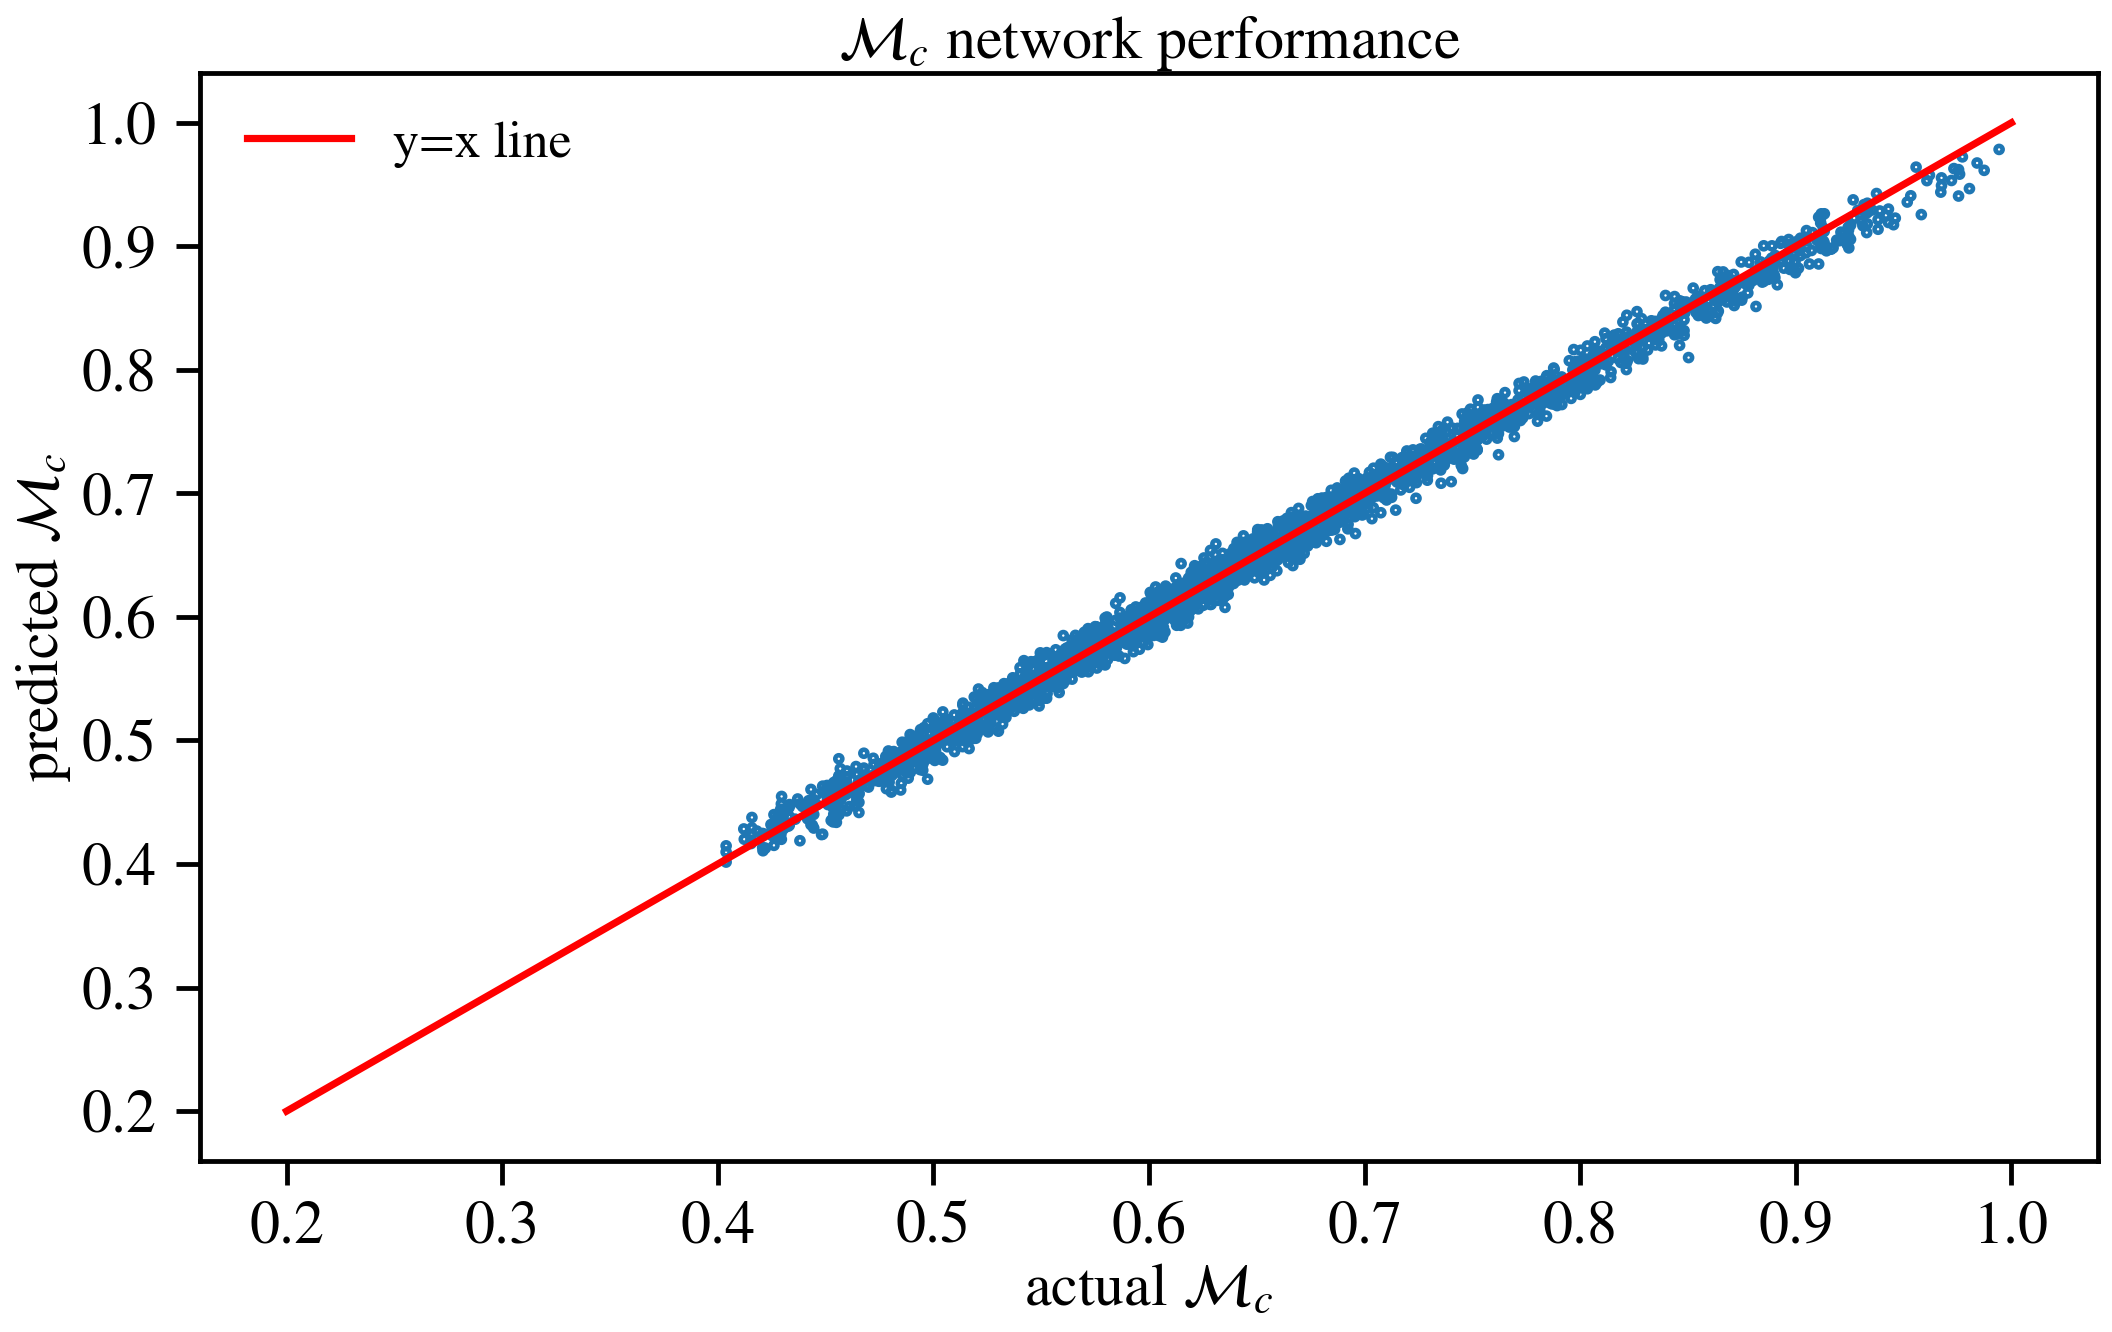

In [43]:
#plotting of network performance on chirp mass
plt.figure(figsize=(17, 10))
plt.scatter(y_test[:, 0], test_predictions[:, 0], s=5)
plt.ylabel(r"predicted $\mathcal{M}_c$"); plt.xlabel(r"actual $\mathcal{M}_c$")
plt.plot([0.2, 1], [0.2, 1], c='r', label = "y=x line")
plt.legend()
plt.title(r"$\mathcal{M}_c$ network performance")
plt.show()

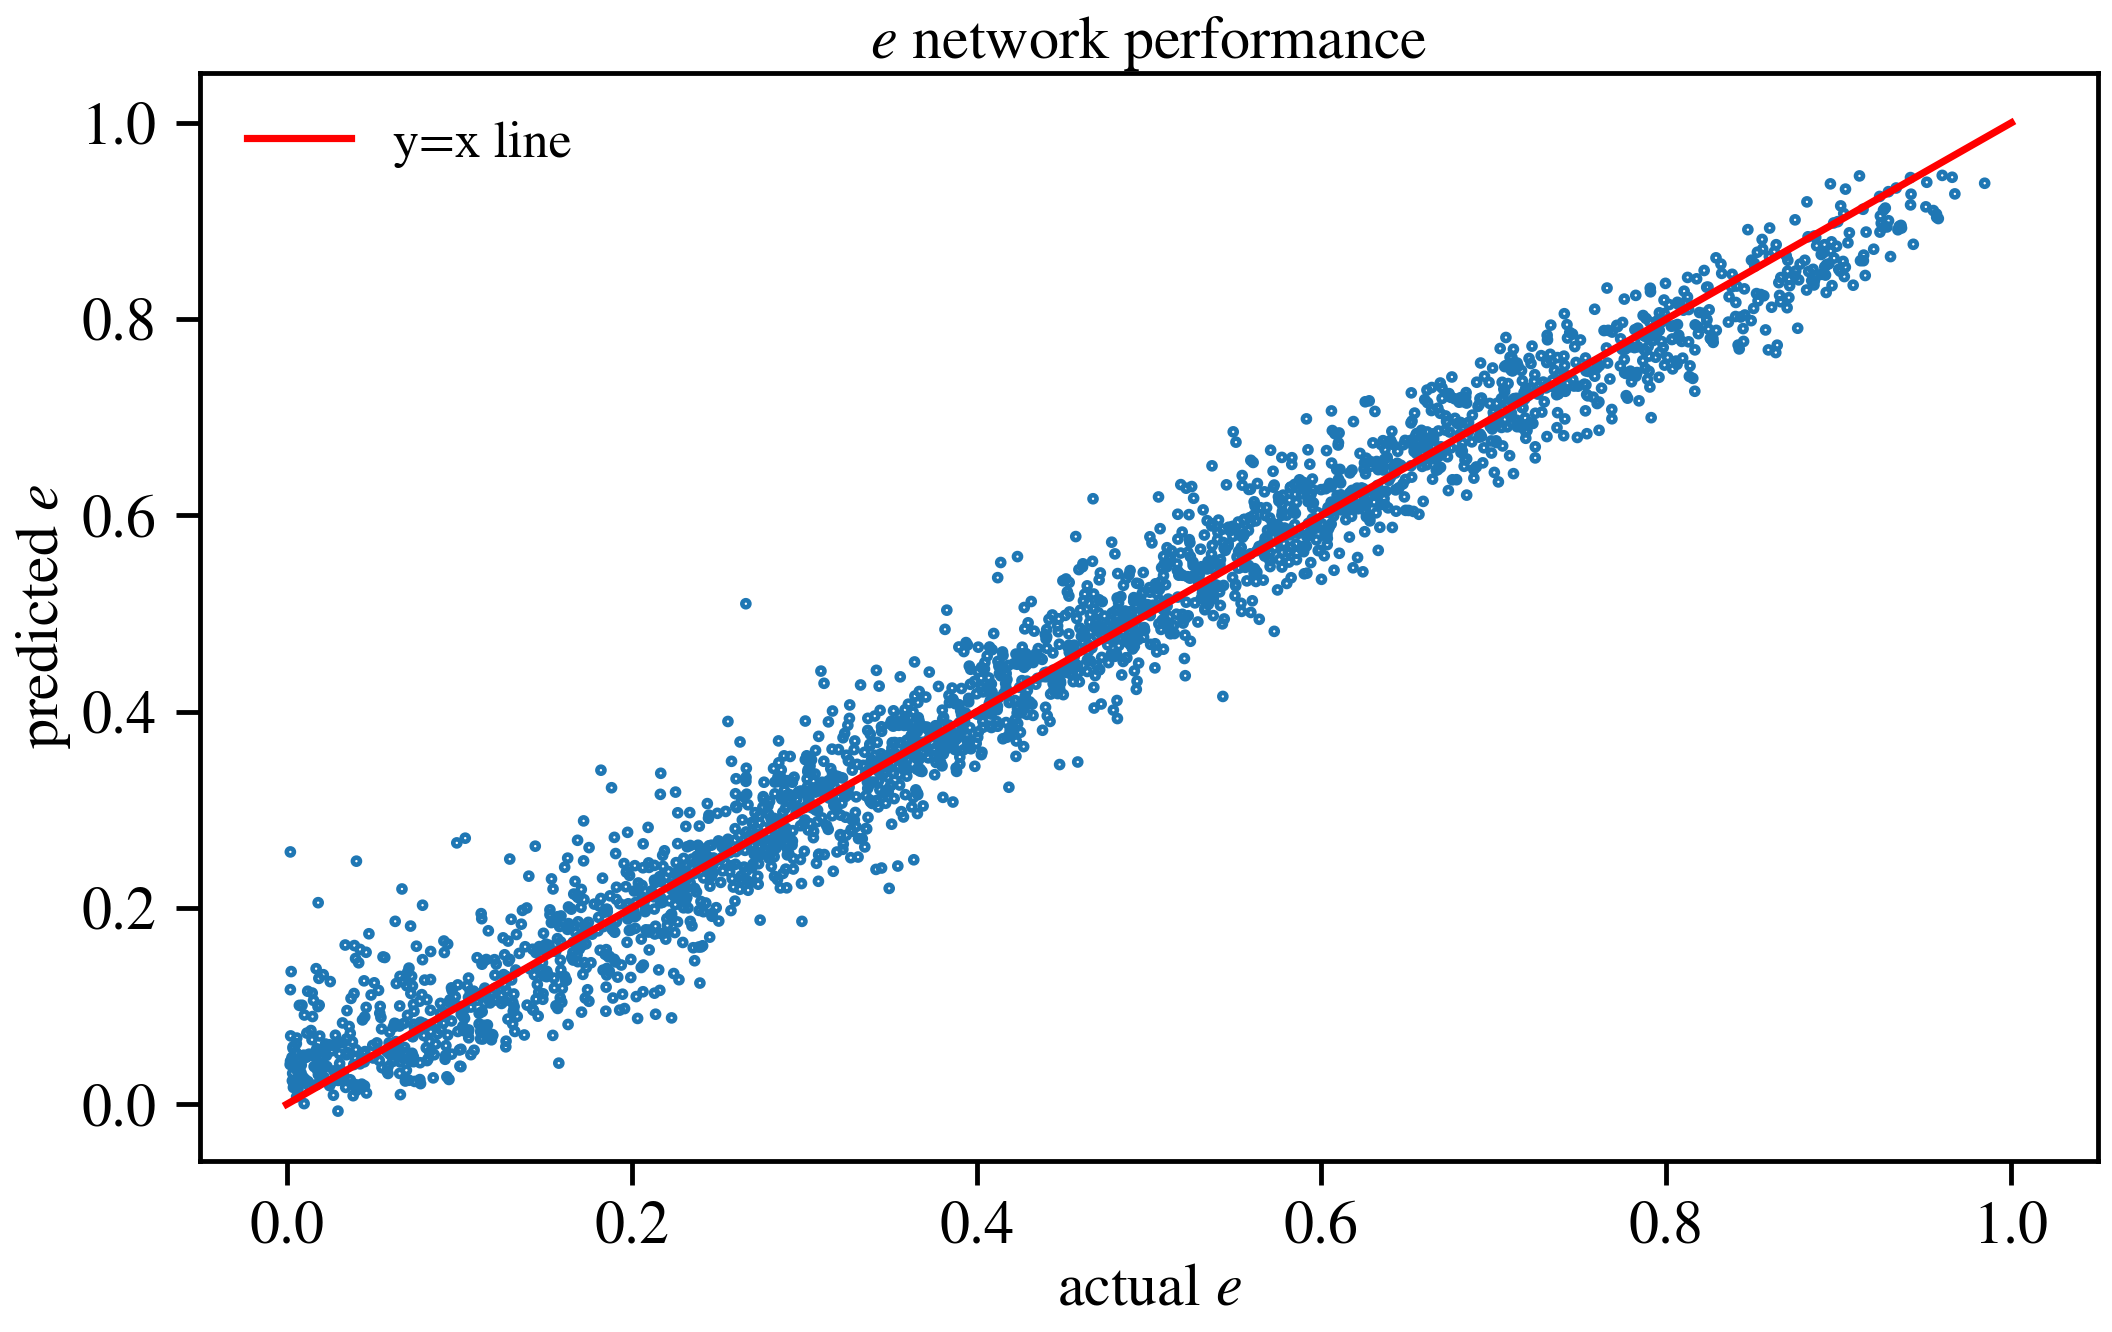

In [42]:
##plotting of network performance on eccentricity
plt.figure(figsize=(17, 10))
plt.scatter(y_test[:, 1], test_predictions[:, 1], s=5)
plt.ylabel(r"predicted $e$"); plt.xlabel(r"actual $e$")
plt.plot([0.0, 1], [0.0, 1], c='r', label = "y=x line")
plt.legend()
plt.title(r"$e$ network performance")
plt.show()